In [1]:
import pandas as pd
import numpy as np
import pickle
import random
import igraph as ig      ## pip install python-igraph
import partition_igraph  ## pip install partition-igraph
import hypernetx as hnx
import hypernetx.algorithms.hypergraph_modularity as hmod
import hypernetx.algorithms.generative_models as gm


# Main functions for Hypergraph Modularity using HyperNetX

### Pre-computing key hypergraph quantities

Given some hnx hypergraph HG, the following function needs to be called first
to pre-compute node strengths (weighted degrees), d-degrees and binomial coefficients
and add these as attributes to HG:

```python
hmod.precompute_attributes(HG)
```

### H-modularity (qH)

The function to compute H-modularity for HG w.r.t. partition A (list of sets covering the vertices):

```python
hmod.hypergraph_modularity(HG, A, wcd=linear)
```

where 'wcd' is the weight function (default = 'linear'). Other choices are 'strict'
and 'majority', or any user-supplied function with the following format:

```python
def linear(d,c):
    return c/d if c>d/2 else 0
```

where $d$ is the edge size, and $c$ is the number of nodes in the majority class, $d \geq c > \frac{d}{2}$

### Two-section graph

Build the random-walk based $2$-section graph given some hypergraph HG:

```python
G = hmod.two_section(HG)
```

where G is an igraph Graph.

### Clustering: Kumar algorithm

Given hypergraph HG, compute a partition of the vertices as per Kumar's algorithm described in [1].

```python
K = hmod.kumar(HG, delta=.01)
```

where delta is the convergence stopping criterion. Partition is returned as a list of sets.

[1] Kumar T., Vaidyanathan S., Ananthapadmanabhan H., Parthasarathy S., Ravindran B. (2020) *A New Measure of Modularity in Hypergraphs: Theoretical Insights and Implications for Effective Clustering*. In: Cherifi H., Gaito S., Mendes J., Moro E., Rocha L. (eds) Complex Networks and Their Applications VIII. COMPLEX NETWORKS 2019. Studies in Computational Intelligence, vol 881. Springer, Cham. https://doi.org/10.1007/978-3-030-36687-2_24


### Clustering: Simple qH-based algorithm

Given hypergraph HG and initial partition L, 
compute a partition of the vertices as per Last-Step algorithm described in [2].

```python
A = hmod.last_step(HG, L, wdc=linear, delta = .01)
```

where 'wcd' is the the weight function (default = 'linear') and delta is the convergence stopping criterion.
Returned partition is a list of sets.

[2] Kamiński B., Prałat P. and Théberge F. “Community Detection Algorithm Using Hypergraph Modularity”. In: Benito R.M., Cherifi C., Cherifi H., Moro E., Rocha L.M., Sales-Pardo M. (eds) Complex Networks & Their Applications IX. COMPLEX NETWORKS 2020. Studies in Computational Intelligence, vol 943. Springer, Cham. https://doi.org/10.1007/978-3-030-65347-7_13

### Utility functions

We use two representations for partitions: list of sets (the parts) or dictionary.
Those functions are used to map from one to the other:

```python
dict2part(D)
part2dict(A)
```

# Toy example

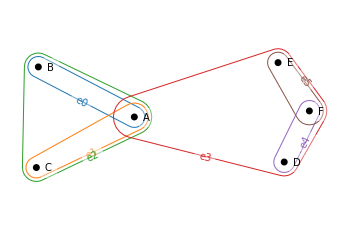

In [2]:
## build a hypergraph from a list of sets (the hyperedges)
E = [{'A','B'},{'A','C'},{'A','B','C'},{'A','D','E','F'},{'D','F'},{'E','F'}]
HG = hnx.Hypergraph(E,static=True)
hnx.draw(HG)


In [3]:
## compute node strength (add unit weight if unweighted), d-degrees, binomial coefficients
HG = hmod.precompute_attributes(HG)

In [4]:
## list the edges (unit weights added by default)
for e in HG.edges:
    print(e,'has weight',HG.edges[e].weight)


e0 has weight 1
e1 has weight 1
e2 has weight 1
e3 has weight 1
e4 has weight 1
e5 has weight 1


In [5]:
## list the nodes (here strength = degree since all weights are 1)
for v in HG.nodes:
    print(v,'has strength',HG.nodes[v].strength)  


A has strength 4
B has strength 2
C has strength 2
F has strength 3
D has strength 2
E has strength 2


In [6]:
## total edge weight for each edge cardinality
HG.d_weights


Counter({2: 4, 3: 1, 4: 1})

In [7]:
## compute hypergraph modularity (qH) for the following partitions:
A1 = [{'A','B','C'},{'D','E','F'}]
A2 = [{'B','C'},{'A','D','E','F'}]
A3 = [{'A','B','C','D','E','F'}]
A4 = [{'A'},{'B'},{'C'},{'D'},{'E'},{'F'}]

## we compute with 3 different choices of functions for the edge contribution: linear (default), strict and majority
strict = hmod.strict
majority = hmod.majority

print('linear edge contribution:')
print('qH(A1):',hmod.modularity(HG,A1),
      'qH(A2):',hmod.modularity(HG,A2),
      'qH(A3):',hmod.modularity(HG,A3),
      'qH(A4):',hmod.modularity(HG,A4))
print('strict edge contribution:')
print('qH(A1):',hmod.modularity(HG,A1,strict),
      'qH(A2):',hmod.modularity(HG,A2,strict),
      'qH(A3):',hmod.modularity(HG,A3,strict),
      'qH(A4):',hmod.modularity(HG,A4,strict))
print('majority edge contribution:')
print('qH(A1):',hmod.modularity(HG,A1,majority),
      'qH(A2):',hmod.modularity(HG,A2,majority),
      'qH(A3):',hmod.modularity(HG,A3,majority),
      'qH(A4):',hmod.modularity(HG,A4,majority))


linear edge contribution:
qH(A1): 0.414445267489712 qH(A2): -0.03746831275720153 qH(A3): 0.0 qH(A4): -0.19173004115226341
strict edge contribution:
qH(A1): 0.43490699588477366 qH(A2): -0.02385843621399164 qH(A3): 0.0 qH(A4): -0.12887572016460908
majority edge contribution:
qH(A1): 0.39379753086419755 qH(A2): -0.0343506172839505 qH(A3): 0.0 qH(A4): -0.22078024691358022


In [8]:
## 2-section graph
G = hmod.two_section(HG)
G.vs['label'] = G.vs['name']
ig.plot(G,bbox=(0,0,250,250))


AttributeError: Plotting not available; please install pycairo or cairocffi

In [ ]:
## 2-section clustering with ECG
G.vs['community'] = G.community_ecg().membership
hmod.dict2part({v['name']:v['community'] for v in G.vs})


In [ ]:
## Clustering with Kumar's algorithm
hmod.kumar(HG)

In [ ]:
## hypergraph clustering -- start from trivial partition A4 defined above
print('start from:',A4)
A = hmod.last_step(HG,A4)
print('final partition:',A)


# Chung-Lu hypergraph example

We build a Chung-Lu hypergraph and compute modularity for partitions from 3 algorithms:
* Louvain, on the 2-section graph
* Kumar algorithm
* LastStep algorithm

We use the **strict** modularity, so only edges where all vertices are in the same part will add to the modularity.
For each algorithm, we compute the modularity qH and compare with the number of edges where all vertices are in the same part.


In [ ]:
## Chung-Lu hypergraph
n = 200
k1 = {i : random.randint(2, 10) for i in range(n)}  ## node degrees
k2 = {i : sorted(k1.values())[i] for i in range(n)} ## edge sizes
H = gm.chung_lu_hypergraph(k1, k2)

## pre-compute required quantities
HG = hmod.precompute_attributes(H)


In [ ]:
## Louvain algorithm on the 2-section graph
G = hmod.two_section(HG)
G.vs['louvain'] = G.community_multilevel().membership
D = {v['name']:v['louvain'] for v in G.vs}
ML = hmod.dict2part(D)

## Compute qH
print('qH =',hmod.modularity(HG, ML, strict))

## number of edges where all vertices belong to the same community
print('edges with all vertices in same part:',
      sum([len(set([D[v] for v in HG.edges[e]]))==1 for e in HG.edges()]))


In [ ]:
## Kumar algorithm
KU = hmod.kumar(HG)

## Compute qH
print('qH =',hmod.modularity(HG, KU, strict))

## number of edges where all vertices belong to the same community
print('edges with all vertices in same part:',
      sum([len(set([hmod.part2dict(KU)[v] for v in HG.edges[e]]))==1 for e in HG.edges()]))


In [ ]:
## Last-step algorithm using previous result as initial partition
LS = hmod.last_step(HG, KU, strict)

## Compute qH
print('qH =',hmod.modularity(HG, LS, strict))

## number of edges where all vertices belong to the same community
print('edges with all vertices in same part:',
      sum([len(set([hmod.part2dict(LS)[v] for v in HG.edges[e]]))==1 for e in HG.edges()]))


# Game of Thrones scenes hypergraph

REF: https://github.com/jeffreylancaster/game-of-thrones

We built an hypergraph from the game of thrones scenes with he following elements:

* **Nodes** are characters in the series
* **Hyperedges** are groups of character appearing in the same scene(s)
* **Hyperedge weights** are total scene(s) duration in seconds involving those characters

We kept hyperedges with at least 2 characters.
Moreover, we discarded characters with degree below 5.

We saved the following:

* *Edges*: list of sets where the nodes are 0-based integers represents as strings
* *Names*: dictionary; mapping of nodes to character names
* *Weights*: list; hyperedge weights (in same order as Edges)


In [ ]:
## load the GoT dataset
Edges, Names, Weights = pickle.load(open( "../hypernetx/utils/toys/GoT.pkl", "rb" ))
print(len(Names),'nodes and',len(Edges),'edges')

### Build weighted GoT hypergraph 

In [ ]:
## Nodes are represented as strings from '0' to 'n-1'
H = hnx.Hypergraph(dict(enumerate(Edges)))
## add edge weights
for e in H.edges:
    H.edges[e].weight = Weights[e]
## add full names
for v in H.nodes:
    H.nodes[v].name = Names[v]
## pre-compute required quantities for modularity and clustering
GoT = hmod.precompute_attributes(H)

### Modularity (qH) on a random partition

We use the default choice for the modularity (**linear** weights).
Result for the random partition should be close to 0 and can be negative.

In [ ]:
## generate a random partition into K parts to compare results
K = 5
V = list(GoT.nodes)
p = np.random.choice(K, size=len(V))
RandPart = hmod.dict2part({V[i]:p[i] for i in range(len(V))})
## compute qH
hmod.modularity(GoT, RandPart)

### Generate the 2-section igraph Graph and cluster with Louvain Algorithm


In [ ]:
## build 2-section
G = hmod.two_section(GoT)
## Louvain algorithm
G.vs['louvain'] = G.community_multilevel(weights='weight').membership
ML = hmod.dict2part({v['name']:v['louvain'] for v in G.vs})

## Compute qH
print('qH =',hmod.modularity(GoT, ML))

### Cluster hypergraph with Kumar's algorithm


In [ ]:
## run Kumar's algorithm, get partition
KU = hmod.kumar(GoT)
## Compute qH
print('qH =',hmod.modularity(GoT, KU))

### Cluster with simple H-based (Last Step) Algorithm

We use Louvain on the 2-section or Kumar algorithm for the initial partition

In [ ]:
## H-based last step with Louvain parition already computed
LS = hmod.last_step(GoT, ML)
## Compute qH
print('qH =',hmod.modularity(GoT, LS))


### Example: show top nodes in same cluster as Daenerys Targaryen


In [ ]:
## Index for 
inv_map = {v: k for k, v in Names.items()}
DT = inv_map['Daenerys Targaryen']
## DT's cluster
DT_part = hmod.part2dict(LS)[DT]
## Build dataframe: all nodes in DT_part
L = []
for n in LS[DT_part]:
    L.append([Names[n],GoT.nodes[n].strength])
D = pd.DataFrame(L, columns=['character','strength'])
D.sort_values(by='strength',ascending=False).head(5)